# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether sth is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [2]:
import sklearn

In [3]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(
    n_samples,
    noise=0.05,
    random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print(f"First 5 samples: {X[:5]}")
print(f"First 5 samples: {y[:5]}")

First 5 samples: [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
First 5 samples: [1 1 1 1 0]


In [6]:
# make a dataframe of circle data
import pandas as pd
circles = pd.DataFrame({
    "X0": X[:, 0],
    "X1": X[:, 1],
    "y": y})
circles.head()

,X0,X1,y
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


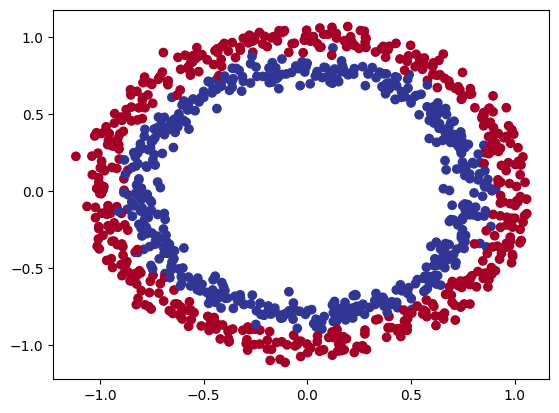

In [7]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu);

**Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"X: {X_sample}\n"
    f"y: {y_sample}\n"
    f"Shape of X: {X_sample.shape}\n"
    f"Shape of y: {y_sample.shape}")

X: [0.74220688 0.24668576]
y: 1
Shape of X: (2,)
Shape of y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'2.6.0+cpu'

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
print(f"dtype of X: {X.dtype}\n"
    f"5 first values of X: {X[:5]}\n"
    f"dtype of y: {y.dtype}\n"
    f"5 first values of y: {y[:5]}\n")

dtype of X: torch.float32
5 first values of X: tensor([[ 0.7422,  0.2467],
        [-0.7340,  0.1687],
        [-0.8299,  0.2220],
        [-0.4291,  0.6722],
        [ 0.4456, -0.8949]])
dtype of y: torch.float32
5 first values of y: tensor([1., 1., 1., 1., 0.])



In [13]:
torch.manual_seed(42)

In [14]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [15]:
print(f"Length of X_train: {len(X_train)}\n"
    f"Length of X_test: {len(X_test)}\n")

Length of X_train: 800
Length of X_test: 200



## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code
2. Construct the model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create train and test loop

In [16]:
import torch
from torch import nn, optim

In [17]:
# Device aganostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers, that are capable of handling the shapes of our data
3. Defines a `forward()` method, that outlines the forward pass (or forward computation) of the model
4. Instantiates an instance of our model class and sends it to the target `device`

In [18]:
# 1. Construct a model that subclasses nn.Module
class CircleModel_1(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data X and y
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # 3. Define the forward method that outlines the forward path
    def forward(self, X):
        return self.layer_2(self.layer_1(X)) # X -> layer_1 -> layer_2

In [19]:
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModel_1().to(device)
model_0, next(model_0.parameters()).device

(CircleModel_1(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='cpu'))

In [20]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1)
).to(device)

model_0, next(model_0.parameters()).device

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='cpu'))

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [22]:
# Make predictions with the model
with torch.inference_mode():
    untrained_preds = model_0(X_train.to(device))
print(f"Length of untrained_preds: {len(untrained_preds)}\n"
    f"Shape: {untrained_preds.shape}\n")
print(f"Length of test samples: {len(y_test)}\n"
    f"Shape: {y_test.shape}\n")
print(f"First 10 predictions: \n{untrained_preds[:10]}\n")
print(f"First 10 actual values: \n{y_train[:10]}\n")

Length of untrained_preds: 800
Shape: torch.Size([800, 1])

Length of test samples: 200
Shape: torch.Size([200])

First 10 predictions: 
tensor([[ 0.2818],
        [ 0.3197],
        [ 0.0157],
        [ 0.0429],
        [-0.0288],
        [ 0.0951],
        [-0.0365],
        [ 0.1214],
        [-0.0728],
        [ 0.3236]])

First 10 actual values: 
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.])



### 2.1 Setup loss function and optimizer

Which loss function or optimizer should one use?

Again... this is problem specific.  
For example for regression one might want MAE or MSE.  
For classification one might want binary or categorical cross entropy.  

As a reminder, the loss function measures how *wrong* the model's predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For some common choices of loss functions and optimizers, check:
  https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article:
  https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition, on what a logit is in deep learning, check:
  https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow/52111173#52111173
* For different optimizers see `torch.optim`


In [23]:
# Setup the loss function
# loss_fn = BCELoss() # Requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation built-in

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [24]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we need to go through the training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)


### 3.1 Going from raw logits to prediction probs to prediction labels

Our model outputs are going to be raw **logits**.  
We can convert these **logits** into prediction probs by passing them to some kind of activation function (e.g. sigmoid for binary crossentropy and softmax for multiclass classification).  
Then we can convert our model's prediction probs to **prediction labels** by either rounding them or taking `argmax()`.

In [25]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0307],
        [-0.0213],
        [ 0.0896],
        [-0.0678],
        [ 0.3020]])

In [26]:
# Use sigmoid activation function on model's logits
y_pred_probs = torch.sigmoid(y_logits)
y_logits

tensor([[-0.0307],
        [-0.0213],
        [ 0.0896],
        [-0.0678],
        [ 0.3020]])

For the prediction prob values, one has to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_prod_probs` < 0.5, `y=0` (class 0)
One can adjust the value.

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logit -> probs -> labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# Put data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and eval loop
for epoch in range(epochs):
  # Train
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss / accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss / acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Prin out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} --- Loss: {loss:.5f} --- Acc: {acc:.2f}% \
    Test loss: {test_loss:.5f} --- Tese acc: {test_acc:.2f}%")

Epoch: 0 --- Loss: 0.69802 --- Acc: 52.25%     Test loss: 0.69432 --- Tese acc: 58.00%
Epoch: 10 --- Loss: 0.69593 --- Acc: 51.25%     Test loss: 0.69299 --- Tese acc: 54.50%
Epoch: 20 --- Loss: 0.69492 --- Acc: 51.38%     Test loss: 0.69249 --- Tese acc: 50.50%
Epoch: 30 --- Loss: 0.69436 --- Acc: 51.25%     Test loss: 0.69232 --- Tese acc: 49.50%
Epoch: 40 --- Loss: 0.69401 --- Acc: 51.00%     Test loss: 0.69229 --- Tese acc: 51.00%
Epoch: 50 --- Loss: 0.69378 --- Acc: 50.38%     Test loss: 0.69231 --- Tese acc: 50.00%
Epoch: 60 --- Loss: 0.69362 --- Acc: 50.12%     Test loss: 0.69237 --- Tese acc: 51.50%
Epoch: 70 --- Loss: 0.69351 --- Acc: 50.12%     Test loss: 0.69245 --- Tese acc: 51.00%
Epoch: 80 --- Loss: 0.69342 --- Acc: 50.00%     Test loss: 0.69253 --- Tese acc: 52.00%
Epoch: 90 --- Loss: 0.69335 --- Acc: 49.50%     Test loss: 0.69262 --- Tese acc: 53.00%


The model is as good as guessing ...

## 4. Make predictions and eval the model

From the metrics it looks like our model isn't learning anything ...  
To inspect it make some predictions and make them visual.  
In other words: "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [32]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch Repo, if not allready downloaded
if Path("helper_functions.py").is_file():
  print("helpor_functions.py already exists, skipping download.")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helpor_functions.py already exists, skipping download.


In [34]:
from helper_functions import plot_predictions, plot_decision_boundary

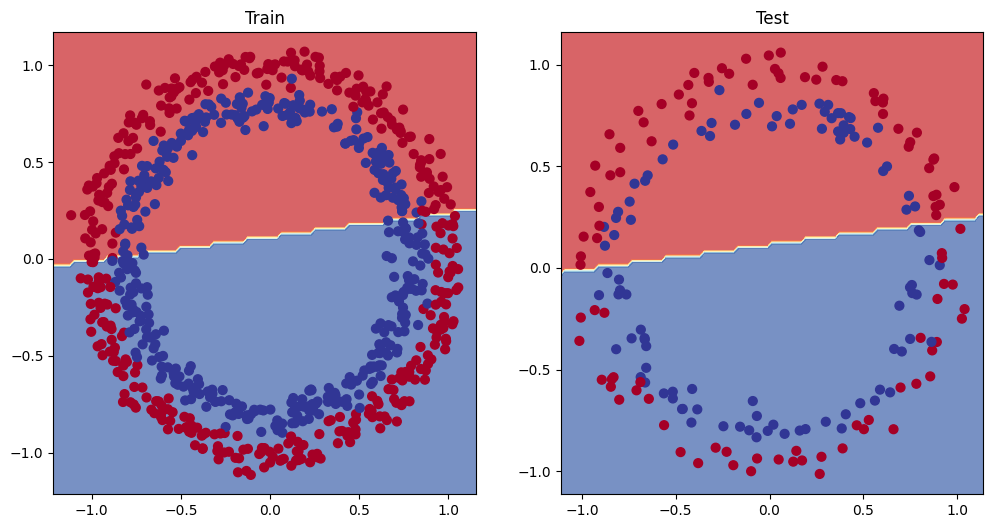

In [35]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

These options are all from a model's perspective, because they deal directly with the model, rather than the data.  

And because these options are all values we (as ML engineers and data scientists) can change, they are referred to as **hyperparameters**.

Try and improve the model by
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [36]:
class CircleModel_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 10)
    self.layer_2 = nn.Linear(10, 10)
    self.layer_3 = nn.Linear(10, 1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [37]:
model_1 = CircleModel_1().to(device)
model_1

CircleModel_1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

In [39]:
# Create an optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [40]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1001

# Put data on the target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  model_1.train()

  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():

    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Prints
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69393 | Acc: 51.00% | Test loss: 0.69264 | Test acc: 50.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.50% | Test loss: 0.69379 | Test acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12% | Test loss: 0.69436 | Test acc: 47.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69456 | Test acc: 46.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.38% | Test loss: 0.69463 | Test acc: 45.50%
Epoch: 500 | Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69465 | Test acc: 45.50%
Epoch: 600 | Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69466 | Test acc: 45.50%
Epoch: 700 | Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69466 | Test acc: 45.50%
Epoch: 800 | Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69466 | Test acc: 45.50%
Epoch: 900 | Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69466 | Test acc: 45.50%
Epoch: 1000 | Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69466 | Test acc: 45.50%


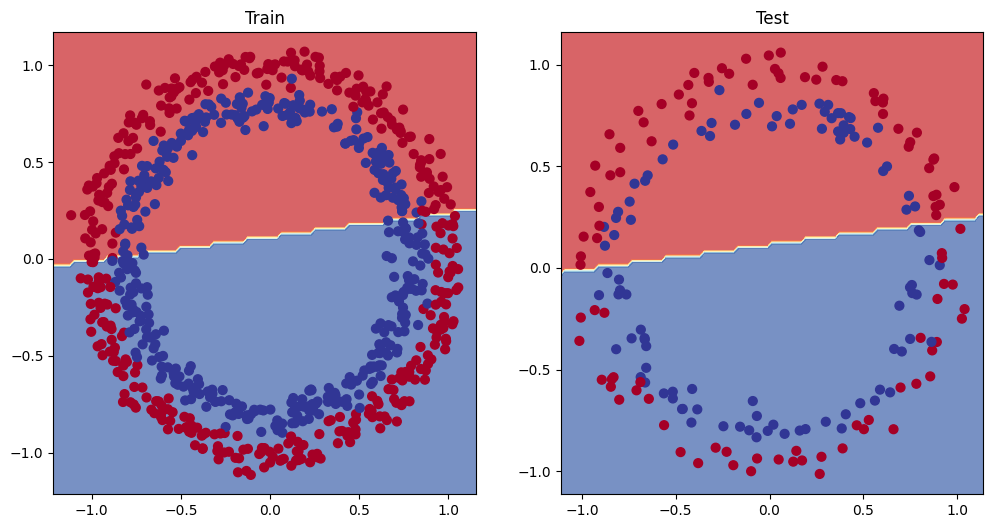

In [41]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is, to test out a smaller problem.

In [42]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [43]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [44]:
len(X_test_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(20, 80, 20, 20)

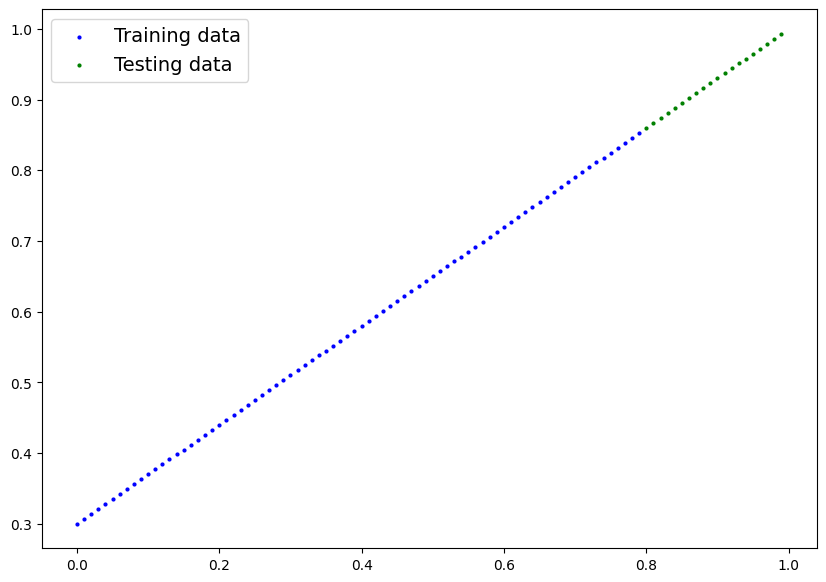

In [45]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [46]:
# Same architecture as model_1 but with using nn.Sequential()
model_2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 1)
).to(device)

In [47]:
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [48]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [49]:
# Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 1001

# Put the data to the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Prints
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test loss: 0.02127
Epoch: 800 | Loss: 0.05600 | Test loss: 0.01425
Epoch: 900 | Loss: 0.05571 | Test loss: 0.00603
Epoch: 1000 | Loss: 0.06455 | Test loss: 0.02425


In [50]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression).squeeze()


In [51]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

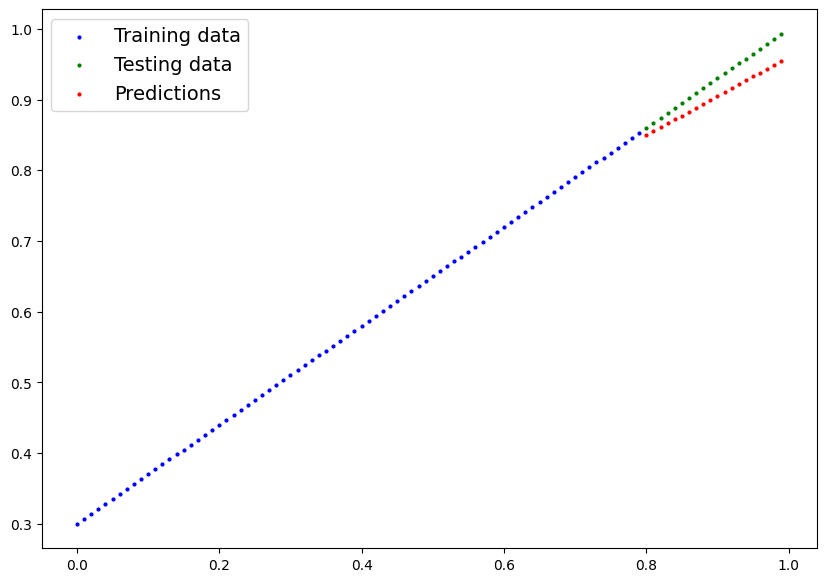

In [52]:
# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: Non-Linearity

"What patterns could one draw if one was given an infinite amount of a straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

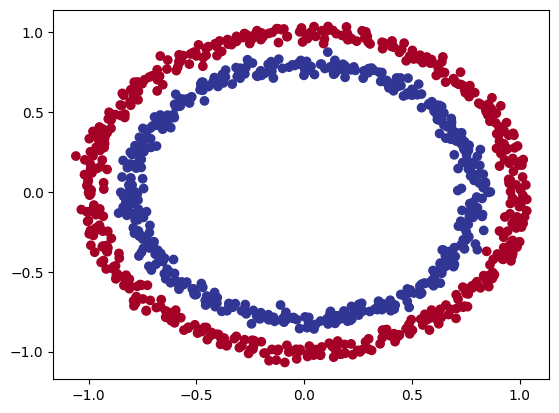

In [53]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42)

plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu);

In [54]:
# Convert data to tensors and then train and test splits
import torch
from sklearn.model_selection import train_test_split

# Tuning data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42)



X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linea (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [55]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [56]:
model_3 = CircleModel_2().to(device)
model_3

CircleModel_2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [57]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [58]:
# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [59]:
# Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 2001

# Training
for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Prints
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} |"
        f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")	

Epoch: 0 | Loss: 0.69295 | Acc: 50.00 |Test loss: 0.69319 | Test acc: 50.00
Epoch: 100 | Loss: 0.69115 | Acc: 52.88 |Test loss: 0.69102 | Test acc: 52.50
Epoch: 200 | Loss: 0.68977 | Acc: 53.37 |Test loss: 0.68940 | Test acc: 55.00
Epoch: 300 | Loss: 0.68795 | Acc: 53.00 |Test loss: 0.68723 | Test acc: 56.00
Epoch: 400 | Loss: 0.68517 | Acc: 52.75 |Test loss: 0.68411 | Test acc: 56.50
Epoch: 500 | Loss: 0.68102 | Acc: 52.75 |Test loss: 0.67941 | Test acc: 56.50
Epoch: 600 | Loss: 0.67515 | Acc: 54.50 |Test loss: 0.67285 | Test acc: 56.00
Epoch: 700 | Loss: 0.66659 | Acc: 58.38 |Test loss: 0.66322 | Test acc: 59.00
Epoch: 800 | Loss: 0.65160 | Acc: 64.00 |Test loss: 0.64757 | Test acc: 67.50
Epoch: 900 | Loss: 0.62362 | Acc: 74.00 |Test loss: 0.62145 | Test acc: 79.00
Epoch: 1000 | Loss: 0.56818 | Acc: 87.75 |Test loss: 0.57378 | Test acc: 86.50
Epoch: 1100 | Loss: 0.48153 | Acc: 93.50 |Test loss: 0.49935 | Test acc: 90.50
Epoch: 1200 | Loss: 0.37056 | Acc: 97.75 |Test loss: 0.40595 | T

### 6.4 Evaluating a model with non-linear activation functions

In [60]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 1.]), tensor([1., 0., 1., 0., 1.]))

In [61]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

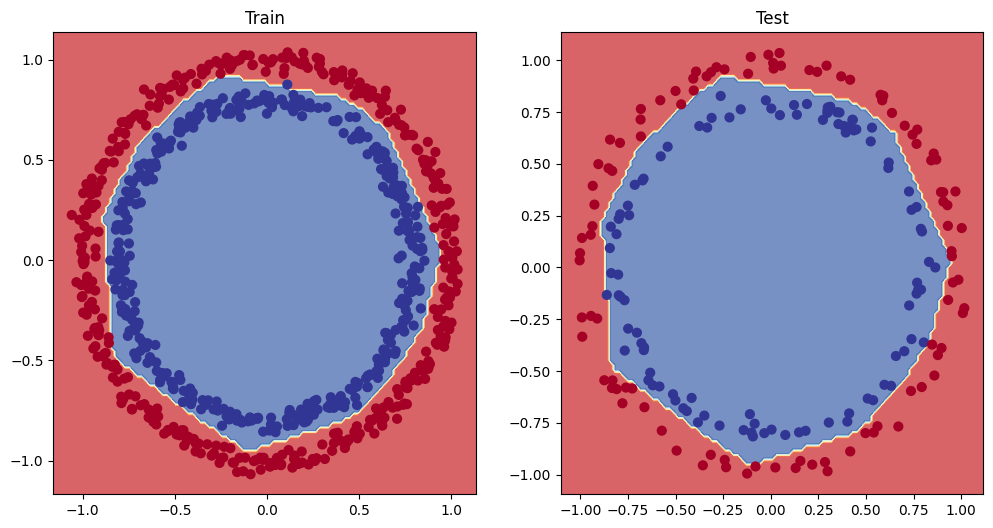

In [62]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


## 7. Replicating non-linear activation functions

Neural Networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [63]:
# Create a tensor
A = torch.arange(-10, 10, 0.1, dtype=torch.float32)

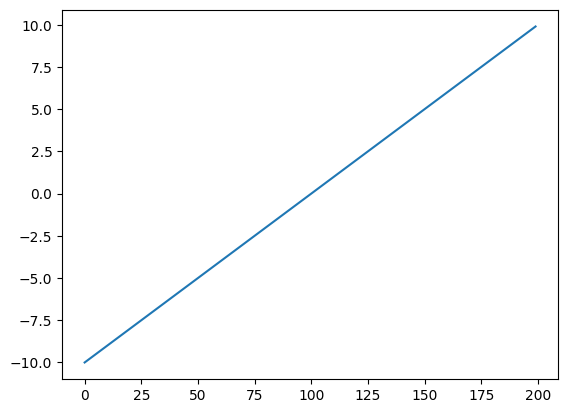

In [64]:
# Visualize the tensor
plt.plot(A);

In [65]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0, dtype=torch.float32), x)

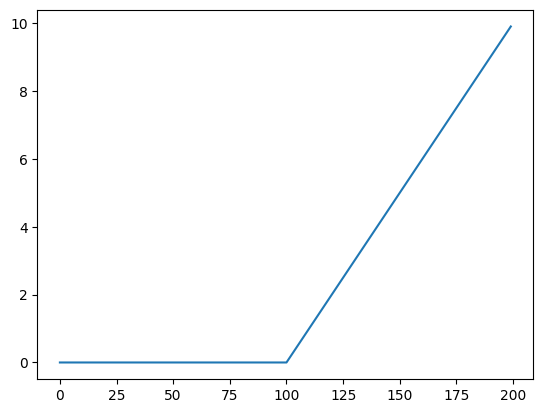

In [66]:
# Apply ReLU to tensor A
plt.plot(relu(A))

In [67]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

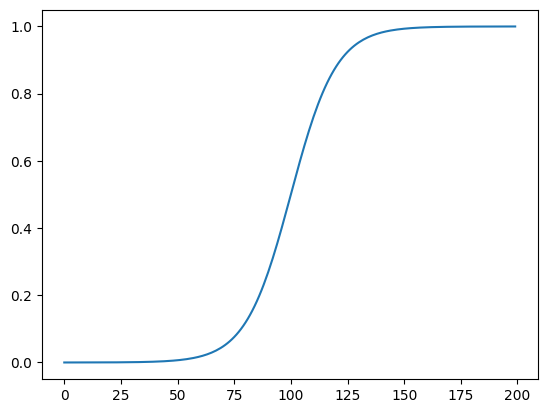

In [68]:
# Apply sigmoid to tensor A
plt.plot(sigmoid(A))

## 8. Putting it all together with a multiclass classification problem

* Binary classification = one thing or another (cat vs dog, spam vs not spam, ...)
* Multiclass classification = more than one thing or another (cat vs dog vs chicken ...)

### 8.1 Import dependencies

In [69]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [70]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [71]:
# Create multiclass data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED)

In [72]:
# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

In [73]:
# Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

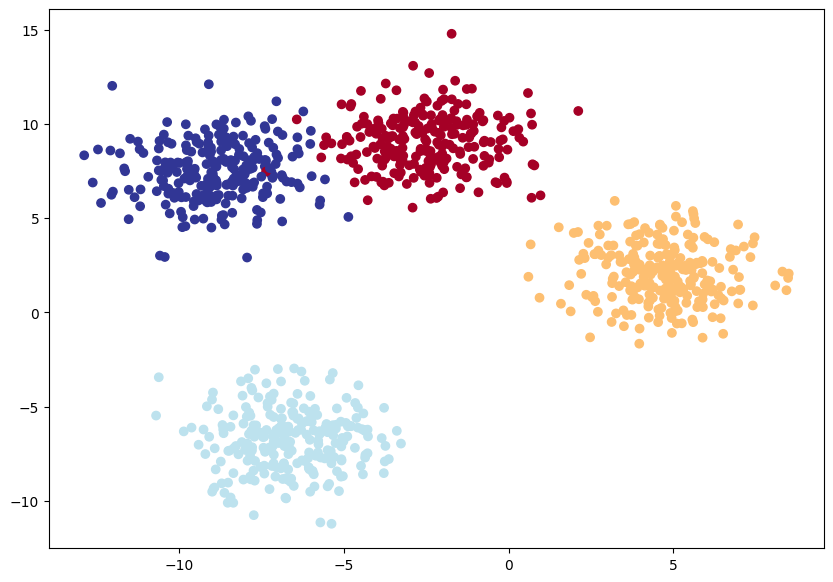

In [74]:
# Plot the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multiclass classification model in PyTorch

In [75]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [76]:
# Create a model
class BlobModel(nn.Module):
    def __init__(self, input_features: int, output_features: int, hidden_size: int = 8):
        """
        Initializes multi-class classification model.

        Args: 
            :input_features: int: number of input features
            :output_features: int: number of output features
            :hidden_size: int: number of hidden units
        """
        
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_features)
        )        


    def forward(self, x):
        return self.linear_layer_stack(x)

In [77]:
# Create an instance of the model
model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_size=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multiclass classification

In [78]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

In [79]:
# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

### 8.4 Getting prediction probs for a multilcass PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels. 

Logits (raw output of the model) -> Pred Probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probs `torch.argmax`)

In [80]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device)) 
y_preds[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

In [81]:
# Convert our model's logits to probabilities
y_pred_probs = torch.softmax(test_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [82]:
torch.sum(y_pred_probs[0]), torch.max(y_pred_probs[0]), torch.argmax(y_pred_probs[0])

(tensor(0.4923), tensor(0.4923), tensor(0))

In [83]:
# Convert model's predictions to labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 0, 0, 0, 0])

### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [84]:
# Fit the multi-class model to the data

# Set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1001

# Put data on the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Training loop
for epoch in range(epochs):
    model_4.train()

    # Forward pass
    y_logits = model_4(X_blob_train)

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train.long())
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # Zero gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test.long())
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    # Print
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.15883 | Acc: 40.38 | Test loss: 1.07554 | Test acc: 48.00
Epoch: 10 | Loss: 0.64476 | Acc: 96.75 | Test loss: 0.66069 | Test acc: 97.50
Epoch: 20 | Loss: 0.42535 | Acc: 98.50 | Test loss: 0.43074 | Test acc: 100.00
Epoch: 30 | Loss: 0.25294 | Acc: 99.12 | Test loss: 0.24508 | Test acc: 99.50
Epoch: 40 | Loss: 0.11232 | Acc: 99.25 | Test loss: 0.10229 | Test acc: 99.50
Epoch: 50 | Loss: 0.06627 | Acc: 99.25 | Test loss: 0.05848 | Test acc: 99.50
Epoch: 60 | Loss: 0.05068 | Acc: 99.25 | Test loss: 0.04293 | Test acc: 99.50
Epoch: 70 | Loss: 0.04300 | Acc: 99.25 | Test loss: 0.03491 | Test acc: 99.50
Epoch: 80 | Loss: 0.03836 | Acc: 99.25 | Test loss: 0.02988 | Test acc: 99.50
Epoch: 90 | Loss: 0.03525 | Acc: 99.25 | Test loss: 0.02663 | Test acc: 99.50
Epoch: 100 | Loss: 0.03312 | Acc: 99.25 | Test loss: 0.02433 | Test acc: 99.50
Epoch: 110 | Loss: 0.03160 | Acc: 99.25 | Test loss: 0.02261 | Test acc: 99.50
Epoch: 120 | Loss: 0.03044 | Acc: 99.25 | Test loss: 0.02126 |

### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [85]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_preds = torch.softmax(model_4(X_blob_test), dim=1).argmax(dim=1)

In [86]:
# View the first 10 predictions
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]),
 tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.]))

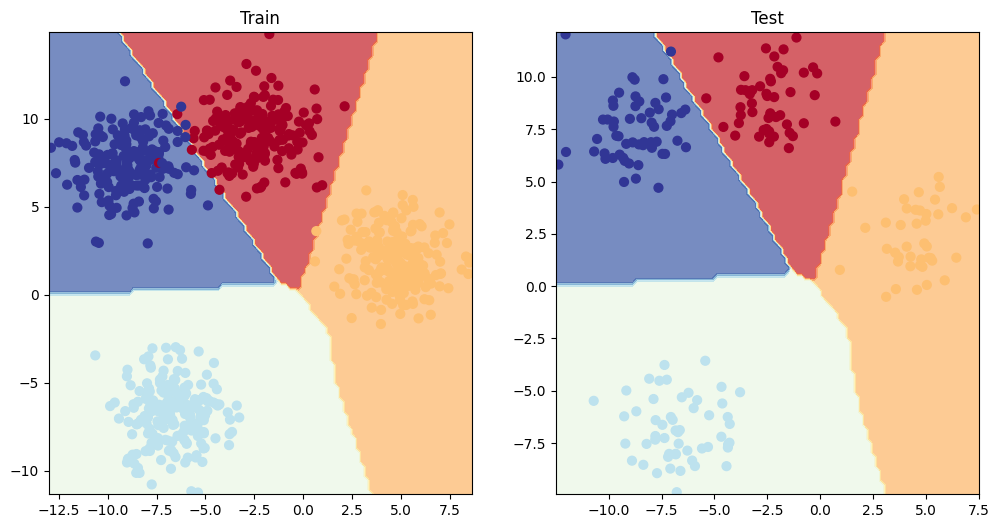

In [87]:
# Get visualizations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


## 9. A few more classification metrics ... (to evaluate the classification model)

* **Accuracy** - Out of 100 samples, how many does the model get right
* **Precision** - 
* **Recall** - 
* **F1-score** - 
* **Confusion matrix** - 
* **Classification matrix** - 

See this article for when to use precision/recall: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want to access to a lot of PyTorch metrics, see TorchMetrics: https://torchmetrics.readthedocs.io/en/latest

In [89]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)

## Exercises and Extra-Curriculum

See here: https://www.learnpytorch.io/02_pytorch_classification/#exercises